## TSML-13_HW2_Elementary methods TS

Взять из прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения, почему была выбрана та или иная модель

In [56]:
import tqdm
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
%matplotlib inline

from math import sqrt
from scipy.stats import boxcox
from scipy.optimize import minimize
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

#### Возьмем DF изменения среднемесячной температуры ("Mean monthly air temperature (Deg. F) Nottingham Castle")

In [57]:
ser_mn_mth_air = pd.read_csv("./data/HW1/mean-monthly-air-temperature-deg.csv")['Deg']

#### Зададим функцию для проведения теста Дики-Фуллера

In [58]:
def test_stationarity(timeseries):
    '''
    Dickey — Fuller test
    '''
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

#### Зададим функцию вывода коррелограмм

In [59]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    '''
    Функция вывода коррелограмм
    '''
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

#### Для проверки ряда на стационарность сделаем тест Дики-Фуллера и посмотрим на коррелограммы

Results of Dickey-Fuller Test:
Test Statistic                  -3.255492
p-value                          0.016989
#Lags Used                      14.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64


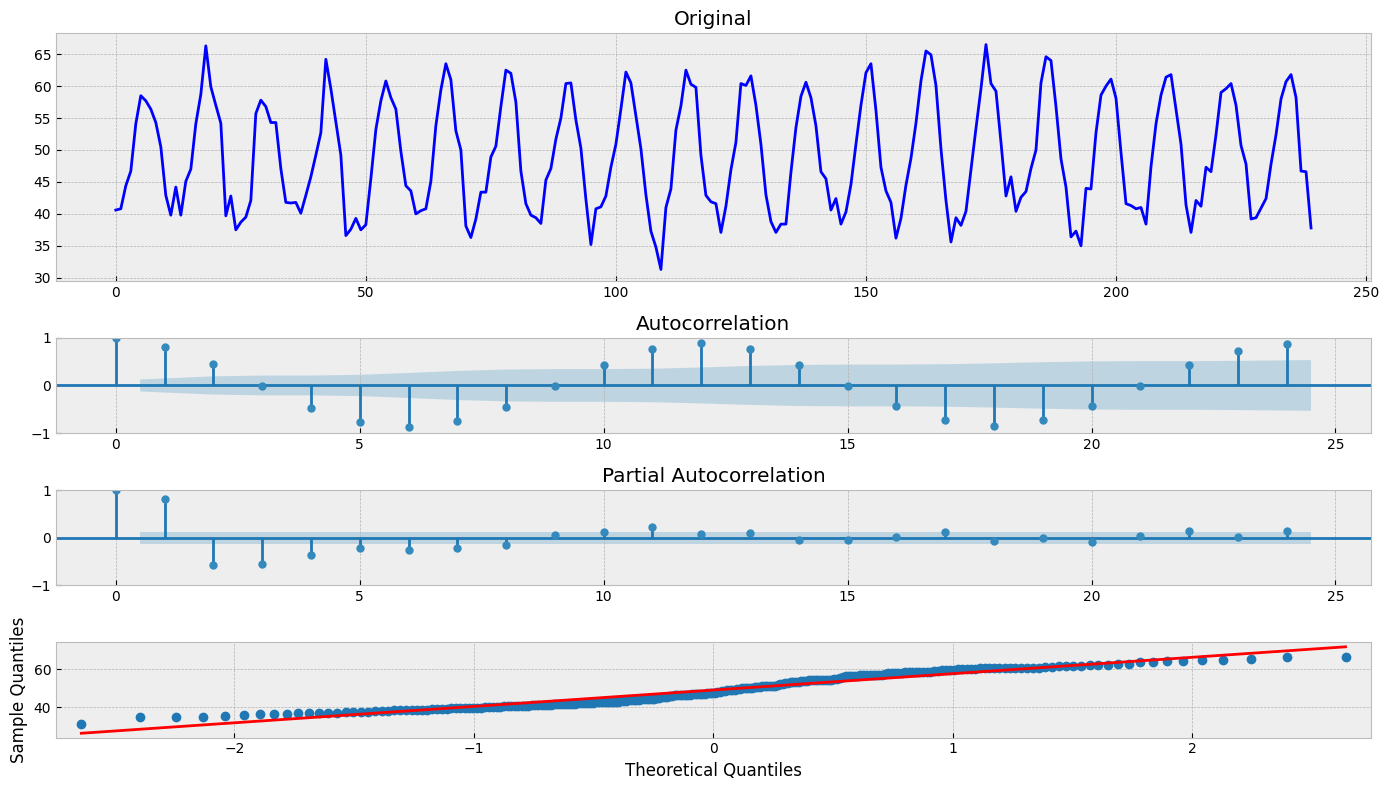

In [61]:
tsplot(ser_mn_mth_air)

#### p-value меньше 0.05
#### Присутствует сезонность, т.е. ряд не является стационарным

In [62]:
def moving_average(series, n):
    '''
    Moving Average function
    '''
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

In [63]:
def weighted_moving_average(series, n, weights):
    '''
    Weighted Moving Average function
    '''
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

In [64]:
def exponential_moving_average(series, alpha):
    '''
    Exponential Moving Average function
    '''
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

#### Попробуем сделать приближение моделями класса MA (Moving Average): 
#### 1) скользящее среднее (MA)
#### 2) взвешенное скользящее среднее (WMA)
#### 3) экспоненциальное скользящее среднее (EMA).

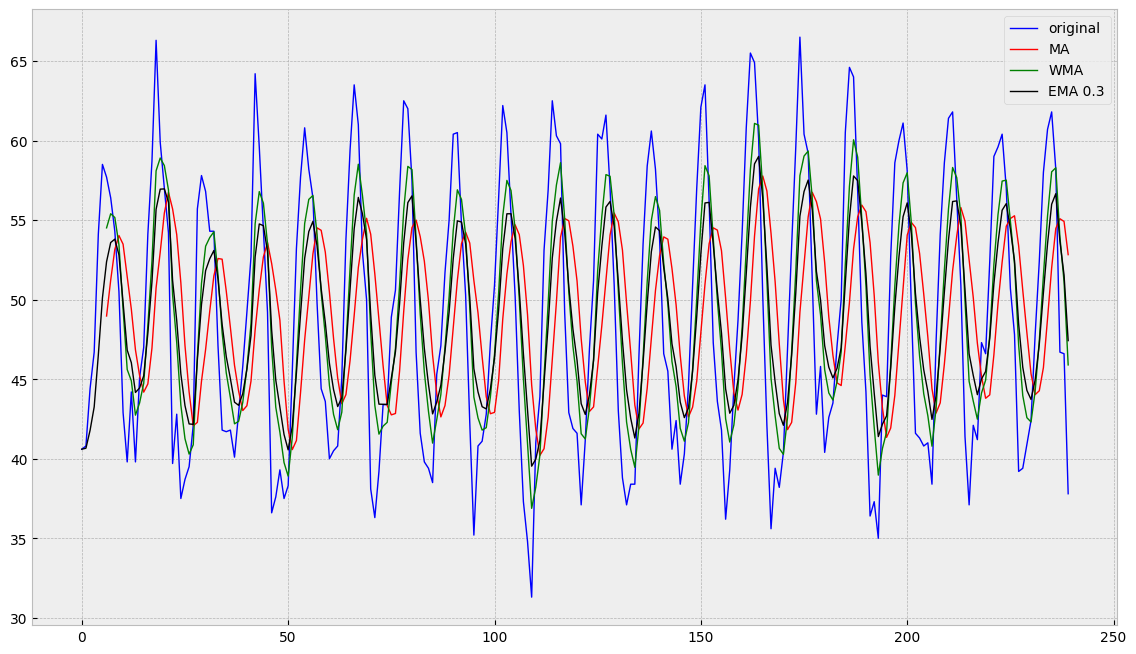

In [65]:
ema = exponential_moving_average(ser_mn_mth_air, 0.3)
wma = weighted_moving_average(ser_mn_mth_air, 7, [1,1,2,3,5,8,13])
ma = moving_average(ser_mn_mth_air, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(ser_mn_mth_air, color='blue', linewidth='1', label='original')
    plt.plot(ma, color='red', linewidth='1', label='MA')
    plt.plot(wma, color='green', linewidth='1', label='WMA')
    plt.plot(ema, color='black', linewidth='1', label='EMA 0.3')
    plt.legend()

#### Приближение происходит в недостаточной "амплитуде". 
#### Попробуем применить разные значения "альфа" для экспоненциального сглаживания (EMA).
#### Параметр "альфа" является сглаживающим фактором. Он определяет, как сильно будем опираться на историю (чем меньше - тем больше). 
#### Чем меньше "альфа", тем больше влияния оказывают предыдущие предсказанные значения, и тем сильнее сглаживается ряд.

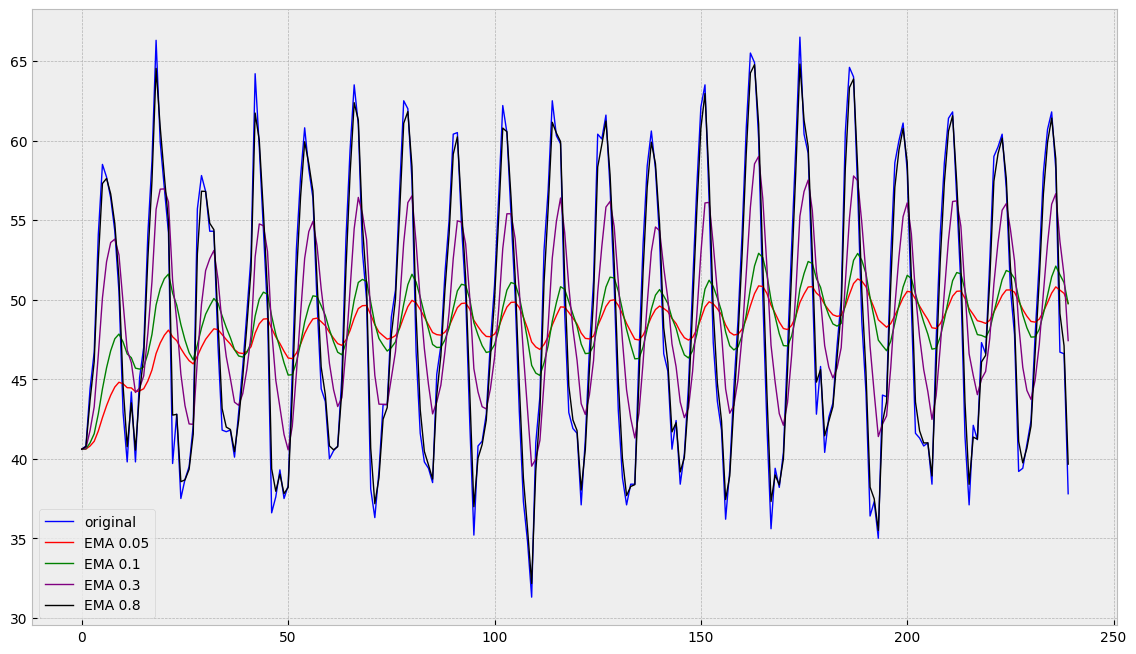

In [66]:
alphas = [0.05, 0.1, 0.3, 0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(ser_mn_mth_air, color='blue', linewidth='1', label='original')
    for i in range(len(alphas)):
        ser_ema = exponential_moving_average(ser_mn_mth_air, alphas[i])
        plt.plot(ser_ema, color=colors[i], linewidth='1', label='EMA {}'.format(alphas[i]))
    plt.legend()

#### Наилучшее сглаживание EMA при "альфа"=0.8, т.е. когда сглаживание ряда минимально. 
#### Попробуем теперь применить тройное экспоненциальное сглаживание (метод Хольта-Винтерса или ТЕМА), т.к. в ряде присутствует ярко выраженная сезонность.

In [67]:
def initial_trend(series, season_len):
    '''
    Trend calculation function
    '''
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [68]:
def initial_seasonal_components(series, slen):
    '''
    Seasonal component calculation function
    '''
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [69]:

def triple_exponential_smoothing(ser_tma, slen, alpha, beta, gamma, n_preds):
    '''
    Triple exponential smoothing calculation function
    '''
    result = []
    seasonals = initial_seasonal_components(ser_tma, slen)
    for i in range(len(ser_tma)+n_preds):
        if i == 0: # initial values
            smooth = ser_tma[0]
            trend = initial_trend(ser_tma, slen)
            result.append(ser_tma[0])
            continue
        if i >= len(ser_tma): # we are forecasting
            m = i - len(ser_tma) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = ser_tma[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [70]:
def plot_tema(alpha, beta, gamma, ser_tema=ser_mn_mth_air, ser_to_plot=ser_mn_mth_air, n_preds=24):
    '''
    TEMA graph display function
    '''
    tema = triple_exponential_smoothing(ser_mn_mth_air, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue', linewidth='1', label='original')
        plt.plot(tema, color='red', linewidth='1', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

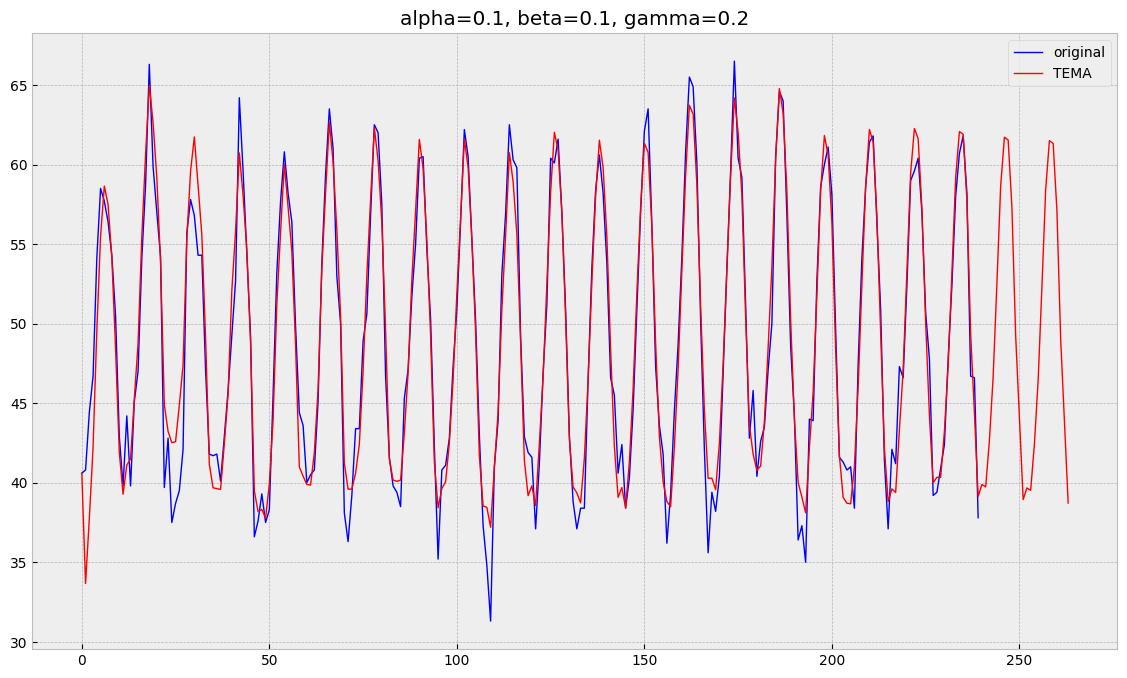

In [71]:
plot_tema(0.1, 0.1, 0.2)

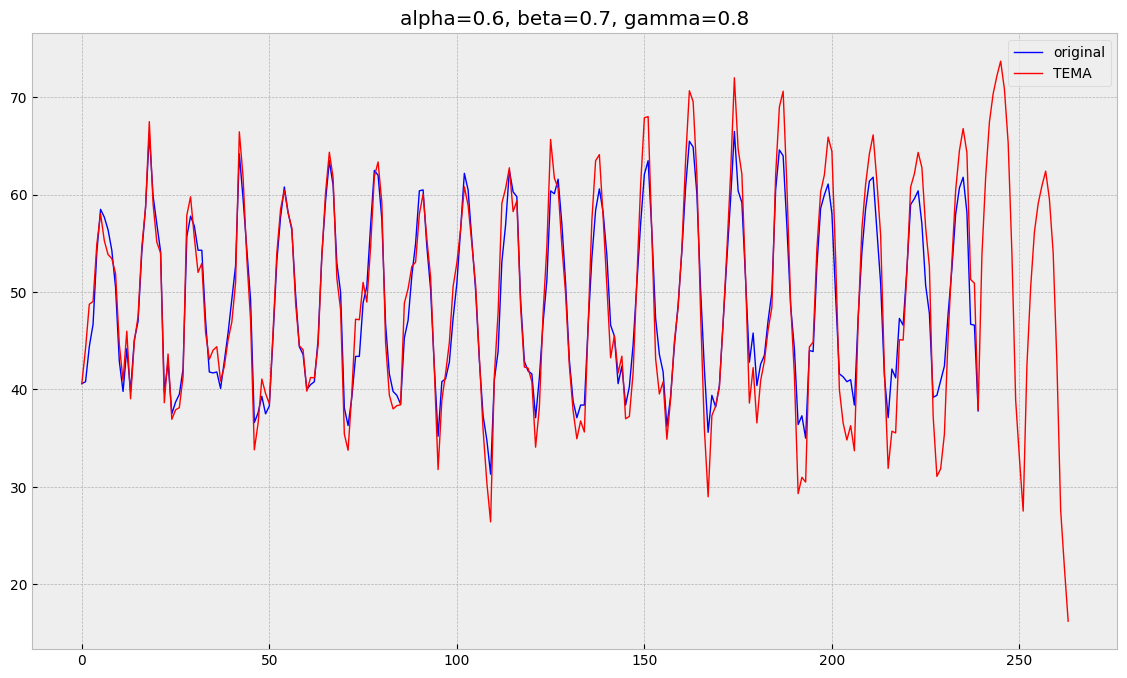

In [72]:
plot_tema(0.6, 0.7, 0.8)

#### Результаты приближения в TEMA получились такими же (а при больших альфа, бета и гамма - хуже), чем при "обычном" EMA c высоким коэфф-том альфа (0.8). 
#### Попробуем оценить качество предсказаний при использовании TEMA (с использованием метрики RMSE) и подобрать оптимальные параметры альфа, бета и гамма.

In [73]:
ser_mn_mth_air_2 = pd.read_csv("./data/HW1/mean-monthly-air-temperature-deg.csv")['Deg']

In [74]:
len(ser_mn_mth_air_2)

240

In [75]:
train, test, val = ser_mn_mth_air_2[:190], ser_mn_mth_air_2[190:230], ser_mn_mth_air_2[230:]

In [76]:
def mse(X):
    '''
    MSE function
    '''
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [77]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [78]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 4.209281339489641
        x: [ 6.651e-01  4.759e-03  1.280e-01]
      nit: 32
      jac: [ 4.441e-07  1.143e-04 -5.329e-07]
     nfev: 180
     njev: 45
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


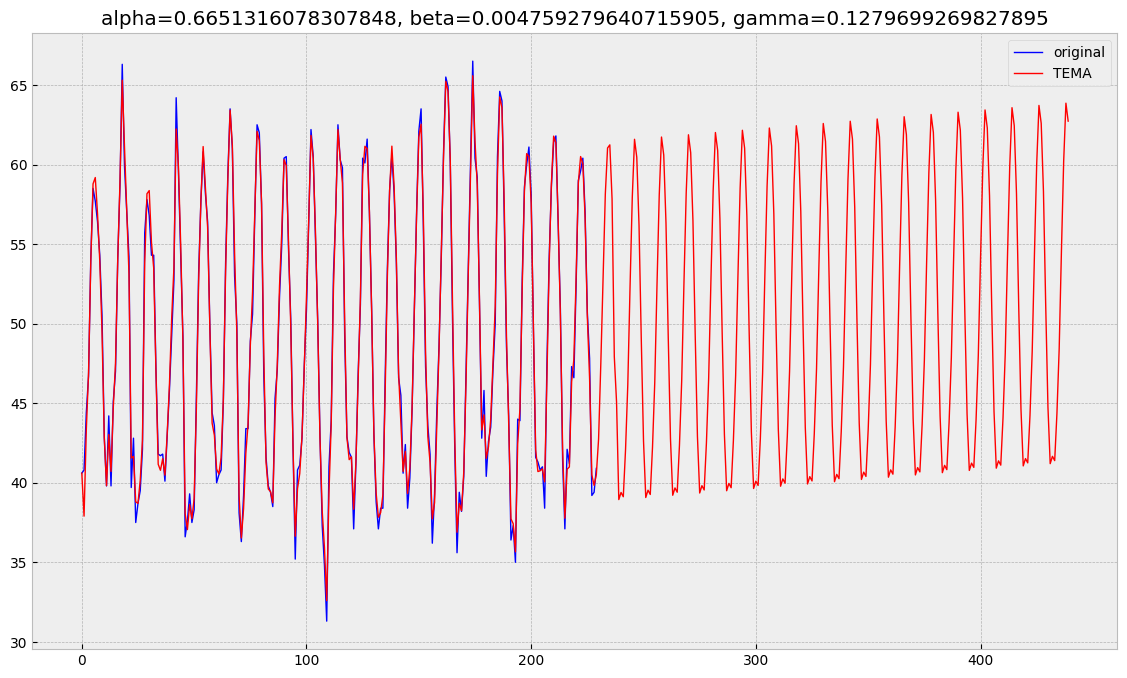

In [79]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser_tema=train, ser_to_plot=ser_mn_mth_air_2[:230], n_preds=len(test)*5)

#### Расчитываем метрику RMSE на найденных оптимальных значениях альфа, бета и гамма.
#### Для этого нужно извлечь квадратный корень из MSE

In [80]:
print(sqrt(mse((alpha_opt, beta_opt, gamma_opt))))

2.051653318543277


#### Для случая с предсказанием исходного нестационарного ряда сделать кросс-валидацию на TEMA.

In [81]:
train, val = ser_mn_mth_air_2[:230], ser_mn_mth_air_2[230:]

In [82]:
def mse_cross_val(X):
    '''
    MSE cross validation on TEMA function
    '''
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
        result = triple_exponential_smoothing(train_split_ts, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))

In [83]:
opt = minimize(mse_cross_val, x0=[0,0,0], method = "L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

73.87701326551462------------
73.87685936025798------------
73.87701326551462------------
73.87700044665243------------
12.084973761783095------------
12.0849736648926------------
12.084986005916676------------
12.084973761783095------------
12.080590046087268------------
12.0805901430169------------
12.080602285767094------------
12.08059004607072------------
12.063038045819438------------
12.063038142896543------------
12.063050268303195------------
12.063038045738061------------
11.992634902437295------------
11.99263499981557------------
11.99264706479856------------
11.992634902114062------------
11.715654979714662------------
11.715655072386445------------
11.715666965646117------------
11.715654978450388------------
10.836975019568056------------
10.836975064061974------------
10.83698488850383------------
10.83697501118377------------
11.136544819758107------------
11.13654476174689------------
11.136551485132275------------
11.136544859984836------------
10.750196583839598----

In [84]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 5.336865460495758
        x: [ 1.756e-02  3.418e-03  2.582e-01]
      nit: 36
      jac: [-1.070e-04 -8.519e-04 -1.661e-05]
     nfev: 256
     njev: 64
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


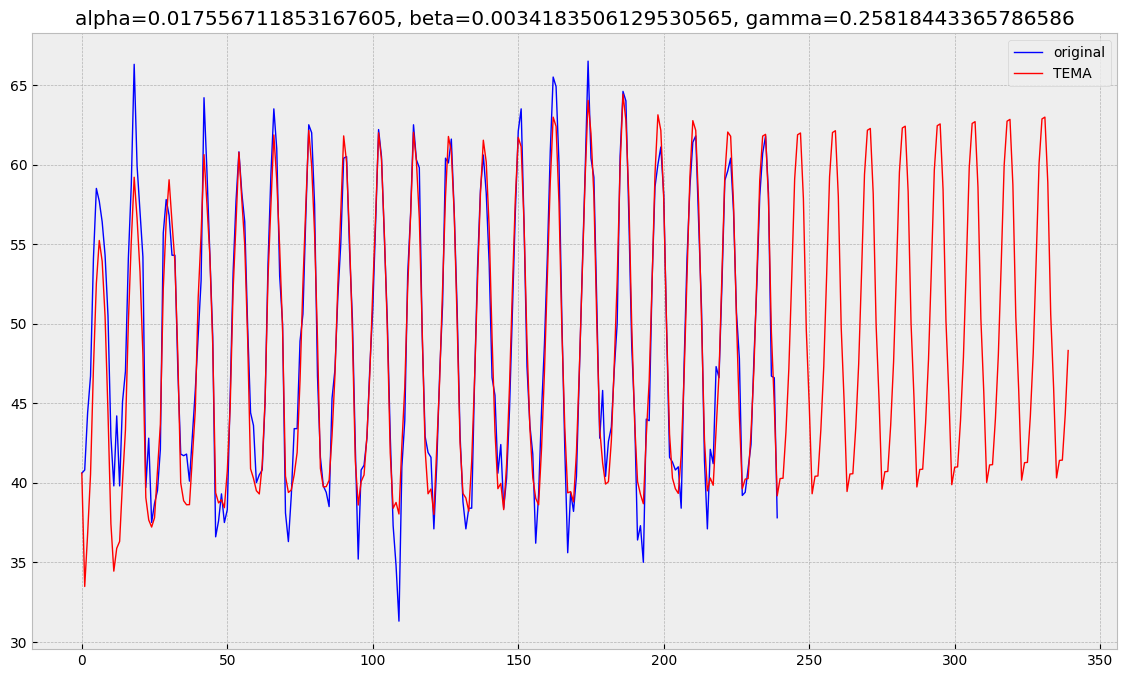

In [85]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser_tema=train, ser_to_plot=ser_mn_mth_air_2, n_preds=len(val)*10)

#### Рассчет RMSE на кросс-валидации

In [89]:
print(sqrt(mse((alpha_opt, beta_opt, gamma_opt))))

14.259360115784892


#### RMSE на кросс-валидации (14.25) получилась выше, чем без кросс-валидации (2.05).

#### Вывод по предсказаниям нестационарного ряда: 
#### 1) Использование TEMA позволило хорошо предсказать сезонность, но модель переобучилась на тренировочных данных.  
#### 2) Наилучший результат визуально показало "одинарное" экспоненциальное сглаживание (EMA) c высоким коэфф-том сглаживания (альфа) = 0.8. 

#### Попробуем теперь сделать ряд стационарным, затем применить к нему TEMA и рассчитать RMSE.

In [122]:
ser_mn_mth_air_3 = pd.read_csv("./data/HW1/mean-monthly-air-temperature-deg.csv")['Deg']

#### Преобразование Бокса-Кокса

In [155]:
ser_mn_mth_air_3_bc = boxcox(ser_mn_mth_air_3, 0)

In [156]:
ser_mn_mth_air_3_bc_diff = np.diff(ser_mn_mth_air_3_bc, 12)

Results of Dickey-Fuller Test:
Test Statistic                -1.513025e+01
p-value                        7.248952e-28
#Lags Used                     1.500000e+01
Number of Observations Used    2.120000e+02
Critical Value (1%)           -3.461578e+00
Critical Value (5%)           -2.875272e+00
Critical Value (10%)          -2.574089e+00
dtype: float64


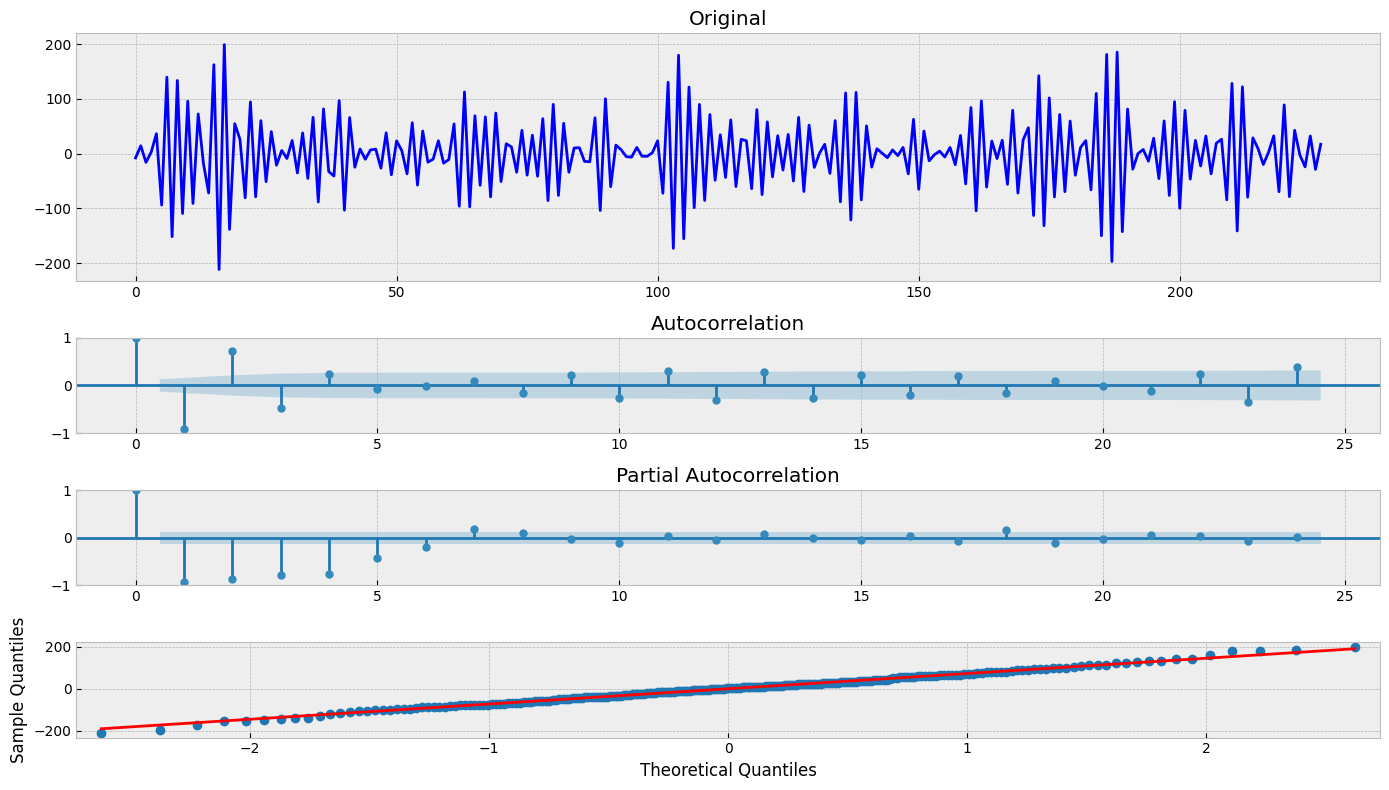

In [157]:
tsplot(ser_mn_mth_air_3_bc_diff)

#### 1) P-value стримится к 0
#### 2) Ушли тренд и сезонность. 
#### 3) Ряд стал стационарным.

In [158]:
len(ser_mn_mth_air_3_bc_diff)

228

In [159]:
train, test, val = ser_mn_mth_air_3_bc_diff[:190], ser_mn_mth_air_3_bc_diff[190:220], ser_mn_mth_air_3_bc_diff[220:]

In [160]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [161]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 4228.2226352235075
        x: [ 3.994e-04  6.420e-01  8.844e-02]
      nit: 143
      jac: [-2.117e+03 -2.067e+00  7.753e+01]
     nfev: 860
     njev: 215
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


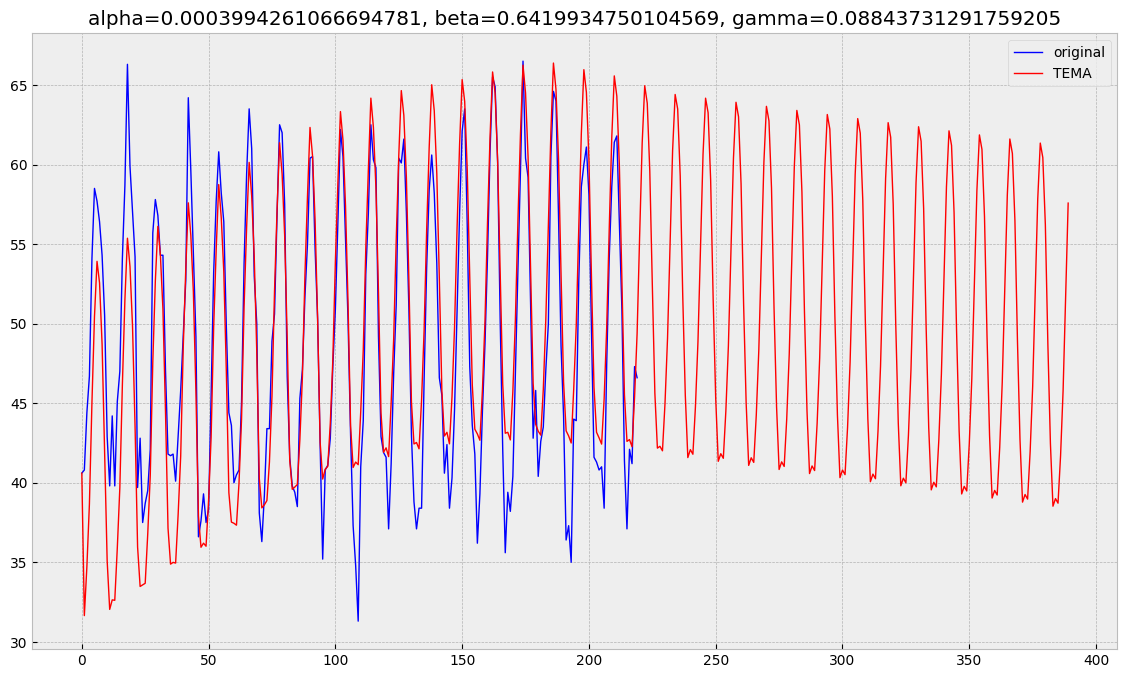

In [162]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser_tema=train, ser_to_plot=ser_mn_mth_air_3[:220], n_preds=len(test)*5)

#### Рассчет RMSE на TEMA со стационарным рядом

In [163]:
print(sqrt(mse((alpha_opt, beta_opt, gamma_opt))))

65.02478477644895


#### 1) RMSE значительно увеличилось по сравнению с кросс-валидацией/TEMA(14.25).
#### 2) Это гораздо больше, чем в случаях предсказаний на нестационарном ряде без кросс-валидации(2.05). 
#### 3) Появились тренды, которых не было на фактических данных. 
###  *Вывод:* 
#### TEMA не очень хорошо подошел для предсказания значений стационарного ряда (приведение ряда к стационарности не требовалось).